<a href="https://colab.research.google.com/github/lucina630/section2_prj/blob/main/AI_13_%EA%B9%80%EC%98%88%EB%82%98_section2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#라이브러리 호출

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns 
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import json
from datetime import timedelta

import sys

#데이터 전처리

In [ ]:
#데이터 불러오기
df = pd.read_csv("/Users/namonk/Library/Mobile Documents/com~apple~CloudDocs/VSC/USvideos.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

In [ ]:
#중복 확인 및 중복값 제거

df["video_id"].duplicated().value_counts()
#True>34598, False>6351

#동영상이 여러 일자에 인기동영상이 될 경우, 일자별로 데이터가 생겨 중복값이 많아짐. 중복값 제거 후 분석 진행
df = df.drop_duplicates(["video_id"])[:]

df["video_id"].duplicated().value_counts()

False    6351
Name: video_id, dtype: int64

In [ ]:
df.isnull().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               102
dtype: int64

카테고리 정보 생성

In [ ]:
id_to_category = {}

with open("/Users/namonk/Library/Mobile Documents/com~apple~CloudDocs/VSC/US_category_id.json","r") as f:
    id_data = json.load(f)
    for category in id_data["items"]:
        id_to_category[category["id"]] = category["snippet"]["title"]

# id_to_category

df["category_id"] = df["category_id"].astype(str)
df.insert(4, "category", df["category_id"].map(id_to_category))

id_to_category

{'1': 'Film & Animation',
 '2': 'Autos & Vehicles',
 '10': 'Music',
 '15': 'Pets & Animals',
 '17': 'Sports',
 '18': 'Short Movies',
 '19': 'Travel & Events',
 '20': 'Gaming',
 '21': 'Videoblogging',
 '22': 'People & Blogs',
 '23': 'Comedy',
 '24': 'Entertainment',
 '25': 'News & Politics',
 '26': 'Howto & Style',
 '27': 'Education',
 '28': 'Science & Technology',
 '29': 'Nonprofits & Activism',
 '30': 'Movies',
 '31': 'Anime/Animation',
 '32': 'Action/Adventure',
 '33': 'Classics',
 '34': 'Comedy',
 '35': 'Documentary',
 '36': 'Drama',
 '37': 'Family',
 '38': 'Foreign',
 '39': 'Horror',
 '40': 'Sci-Fi/Fantasy',
 '41': 'Thriller',
 '42': 'Shorts',
 '43': 'Shows',
 '44': 'Trailers'}

In [ ]:
#생성한 category열에 결측치 있는지 확인
df.isnull().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category                    0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               102
dtype: int64

날짜데이터 수정

In [ ]:
#trending_date와 publish_time을 datime형식으로 변환
 
 
type(df["trending_date"][0])  #str

df["trending_date"] = pd.to_datetime(df["trending_date"],format="%y.%d.%m")
df["trending_date"].head()

type(df["publish_time"][0])

df["publish_time"] = pd.to_datetime(df["publish_time"],format="%Y-%m-%dT%H:%M:%S.%fZ")
df["publish_time"].head()

0   2017-11-13 17:13:01
1   2017-11-13 07:30:00
2   2017-11-12 19:05:24
3   2017-11-13 11:00:04
4   2017-11-12 18:01:41
Name: publish_time, dtype: datetime64[ns]

In [ ]:
# Separate date from time for publish

df["publish_date"] = pd.DatetimeIndex(df["publish_time"]).date
df["publish_date"] = pd.to_datetime(df["publish_date"],format="%Y-%m-%d")
df["publish_date"].head()

df["publish_time_of_day"] = pd.DatetimeIndex(df["publish_time"]).time
df["publish_time_of_day"].head()

# Hour published
df["publish_hour"] = df["publish_time_of_day"].apply(lambda x: x.hour)
df["publish_hour"].head()

0    17
1     7
2    19
3    11
4    18
Name: publish_hour, dtype: int64

In [ ]:
# Add column of days between published and trended

# How about just videos that trended the day of/after they were published

# Pull days trended for each
# Remember, can be zero, if it trends on the day it was published
df["days_trended_after_publish"] = df["trending_date"] - df["publish_date"]

# Change days_trended_after_publish to an integer
df["days_trended_after_publish"] = df["days_trended_after_publish"].dt.days

In [ ]:
# Add column with sum of total days trended per video
trended_count = df.groupby("video_id").count()["days_trended_after_publish"].reset_index()
trended_count.columns = ["video_id","trended_count"]

In [ ]:
df = df.merge(trended_count,on="video_id")

In [ ]:
#동영상 게시 후 얼마 후에 인기동영상에 갔는지
df["treTime-pubTime"] = df["trending_date"] - df["publish_time"] + timedelta(days = 1)

In [ ]:
df["treTime-pubTime"].describe()
#인기동영상들은 동영상을 평균적으로 게시하고 다음 날 인기동영상이 되었습니다. 빠르면 당일에 인기동영상이 되네요.

count                           6351
mean      22 days 22:38:27.931506849
std      209 days 23:10:36.735018068
min                  0 days 10:59:56
25%           1 days 10:58:50.500000
50%                  2 days 02:27:16
75%           3 days 02:46:19.500000
max               4215 days 15:35:49
Name: treTime-pubTime, dtype: object

In [ ]:
pd.cut(df["treTime-pubTime"],[timedelta(days = 0),timedelta(days = 1),timedelta(days = 2),timedelta(days = 3),timedelta(days = 2335)]).value_counts(sort = False,normalize = True)


#게시 후 당일에 인기동영상이 되는 경우가 1%, 2일째에 인기동영상이 되는 경우가 71%, 3일 이내에 인기동영상이 되는 경우가 99%입니다. 게시 후 3일 이내에 인기동영상이 되지 못하면, 인기 동영상이 되기 힘들다고 보입니다.

(0 days 00:00:00, 1 days 00:00:00]       0.018954
(1 days 00:00:00, 2 days 00:00:00]       0.432633
(2 days 00:00:00, 3 days 00:00:00]       0.286211
(3 days 00:00:00, 2335 days 00:00:00]    0.262202
Name: treTime-pubTime, dtype: float64

태그 개수 

In [ ]:
df["tag_count"] = df["tags"].apply(lambda x : len(x.split("|")) if x != "[none]" else 0)

ABOUT LIKES

In [ ]:
df["likes/views"] = df["likes"] / df["views"]
df["dislikes/views"] = df["dislikes"] / df["views"]
df["comment_count/views"] = df["comment_count"] / df["views"]
df["dislikes/likes"] = df["dislikes"] / df["likes"]
df["dislikes/likes"].loc[df["dislikes/likes"] == np.inf] = 0

like_percent = pd.DataFrame((df['likes'] / df['views']) * 100)
dislike_percent = pd.DataFrame((df['dislikes'] / df['views']) * 100)
df['like_percent'] = like_percent
df['dislike_percent'] = dislike_percent

/var/folders/lt/b43bl65n2r38vrn01fzsz2lh0000gn/T/ipykernel_752/4059313078.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["dislikes/likes"].loc[df["dislikes/likes"] == np.inf] = 0


In [ ]:
df['positive_or_negative'] = df['like_percent'] > df['dislike_percent']

In [ ]:
# comparing the likes to dislikes 
video_likes = []
for item in df['positive_or_negative']:
    if item == True:
        video_likes.append(1)
    else:
        video_likes.append(0)

In [ ]:
df['positive_or_negative'] = video_likes

In [ ]:
df["dislikes/likes"].loc[df["dislikes/likes"].isnull() == True] = 0
#결측값 0으로 대체하기

/var/folders/lt/b43bl65n2r38vrn01fzsz2lh0000gn/T/ipykernel_752/486573978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["dislikes/likes"].loc[df["dislikes/likes"].isnull() == True] = 0


In [ ]:
df[["likes/views", "dislikes/views", "comment_count/views", "dislikes/likes"]].describe()

,likes/views,dislikes/views,comment_count/views,dislikes/likes
count,6351.000000,6351.000000,6351.000000,6351.000000
mean,0.040283,0.001720,0.005645,0.112602
std,0.034903,0.004448,0.006932,0.603247
min,0.000000,0.000000,0.000000,0.000000
25%,0.014390,0.000518,0.001882,0.014161
50%,0.031415,0.000913,0.003746,0.029626
75%,0.055363,0.001665,0.006807,0.071064
max,0.290466,0.191531,0.117643,24.048462


제목 길이

In [ ]:
df["title_length"] = df["title"].apply(lambda x : len(str(x)) if pd.isnull(x) == False  else 0 )

EDA

In [ ]:
#전반적인 데이터 분포
print("분석에 사용한 데이터는 {}개의 변수를 가진 인기동영상 데이터 {}개입니다.".format(len(df.columns), format(len(df),",")))

분석에 사용한 데이터는 32개의 변수를 가진 인기동영상 데이터 6,351개입니다.


In [ ]:
df.describe()

,views,likes,dislikes,comment_count,publish_hour,days_trended_after_publish,trended_count,treTime-pubTime,tag_count,likes/views,dislikes/views,comment_count/views,dislikes/likes,like_percent,dislike_percent,positive_or_negative,title_length
count,6.351000e+03,6.351000e+03,6351.000000,6351.000000,6351.000000,6351.000000,6351.0,6351,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000
mean,7.582096e+05,3.449357e+04,1427.222012,4501.707290,13.520863,22.520548,1.0,22 days 22:38:27.931506849,19.811211,0.040283,0.001720,0.005645,0.112602,4.028288,0.172006,0.979373,49.774524
std,1.928993e+06,1.162439e+05,12078.814524,21460.223331,6.493522,209.963344,0.0,209 days 23:10:36.735018068,12.240803,0.034903,0.004448,0.006932,0.603247,3.490346,0.444790,0.142142,19.711426
min,5.490000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.0,0 days 10:59:56,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,8.351100e+04,1.908000e+03,72.000000,261.000000,9.000000,1.000000,1.0,1 days 10:58:50.500000,10.000000,0.014390,0.000518,0.001882,0.014161,1.439044,0.051818,1.000000,35.000000
50%,2.709020e+05,7.987000e+03,242.000000,921.000000,15.000000,2.000000,1.0,2 days 02:27:16,19.000000,0.031415,0.000913,0.003746,0.029626,3.141512,0.091269,1.000000,48.000000
75%,7.512665e+05,2.516300e+04,763.000000,2845.000000,18.000000,3.000000,1.0,3 days 02:46:19.500000,29.000000,0.055363,0.001665,0.006807,0.071064,5.536296,0.166489,1.000000,62.000000
max,4.843165e+07,3.880071e+06,629120.000000,733373.000000,23.000000,4215.000000,1.0,4215 days 15:35:49,69.000000,0.290466,0.191531,0.117643,24.048462,29.046646,19.153148,1.000000,100.000000


<AxesSubplot:>

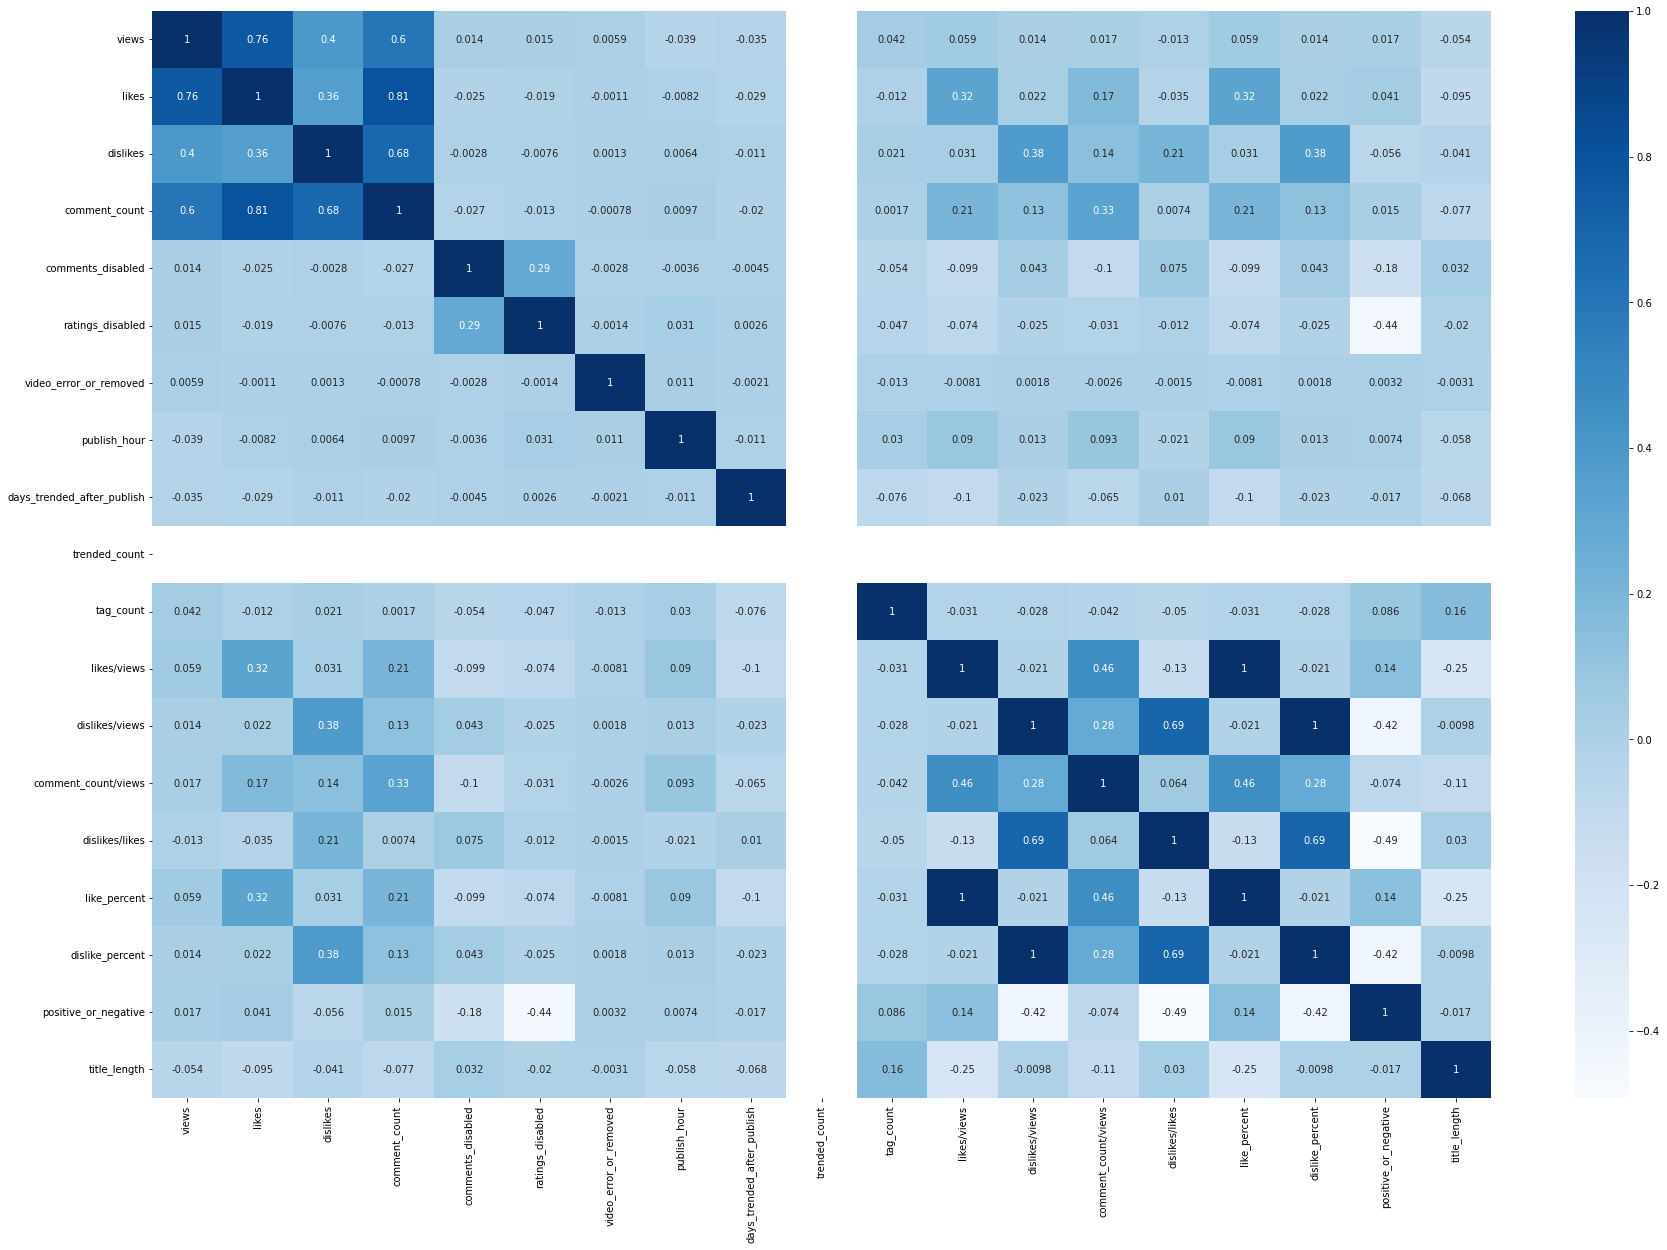

In [ ]:
plt.figure(figsize=(30,20))
sns.heatmap(df.corr(),cmap="Blues",annot=True)
# Note, this might not be a good proxy of much, since some videos are in the dataset multiple times

VIEWS

In [ ]:
df["views"].describe

<bound method NDFrame.describe of 0        748374
1       2418783
2       3191434
3        343168
4       2095731
         ...   
6346     607422
6347     812832
6348     864189
6349     540149
6350     296295
Name: views, Length: 6351, dtype: int64>

In [ ]:
print("전체 데이터 {}건".format(len(df)) )
print("1000만이상 {}건 전체의 {:.2f}%".format(len(df.loc[df["views"] >= 10000000]),len(df.loc[df["views"] >= 10000000]) / len(df) * 100))
print("100만이상 {}건 전체의 {:.2f}%".format(len(df.loc[df["views"] >= 1000000]),len(df.loc[df["views"] >= 1000000]) / len(df) * 100))
print("100만이하 {}건 전체의 {:.2f}%".format(len(df.loc[df["views"] < 1000000]),len(df.loc[df["views"] < 1000000]) / len(df) * 100))

전체 데이터 6351건
1000만이상 38건 전체의 0.60%
100만이상 1161건 전체의 18.28%
100만이하 5190건 전체의 81.72%


조회수 100만 이하 데이터의 평균: 276740.80


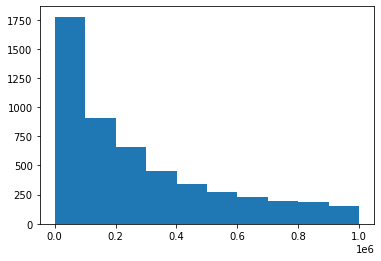

In [ ]:
#극단값 제외후 확인
print("조회수 100만 이하 데이터의 평균: {:.2f}".format(df["views"].loc[df["views"] <= 1000000].mean()))
plt.hist(df["views"].loc[df["views"] <= 1000000]);

#Relationship between time published and views, days trended  

Questions to answer:  

* When should I publish my video? If I publish at a certain time, am I more likely to trend?  
* Do users interact more with videos that are published at a certain time? Because we know that there's a high correlation of views/comments to trending  
* Hyphothesis: It doesn't matter. The correlations between publish hour and everything else is low.



<AxesSubplot:xlabel='publish_hour', ylabel='views'>

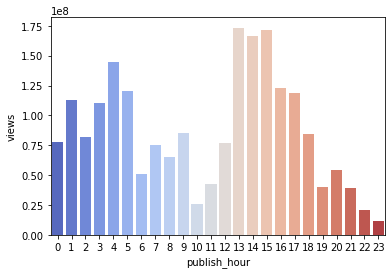

In [ ]:
#publish hour

# Sum of views per video by hour published
sns.barplot(data = df[df["trended_count"] == df["days_trended_after_publish"]].groupby("publish_hour").sum()["views"].reset_index(),x="publish_hour",y="views",palette="coolwarm")

<AxesSubplot:xlabel='publish_hour', ylabel='trended_count'>

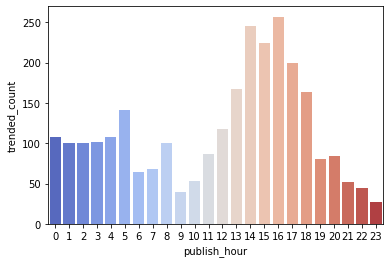

In [ ]:
# Total days trended by hour published
sns.barplot(x="publish_hour",y="trended_count",data=df[df["trended_count"] == df["days_trended_after_publish"]].groupby("publish_hour").sum()["trended_count"].reset_index(),palette="coolwarm")

#요일은 관계가 있을까?

<AxesSubplot:xlabel='publish_day', ylabel='trended_count'>

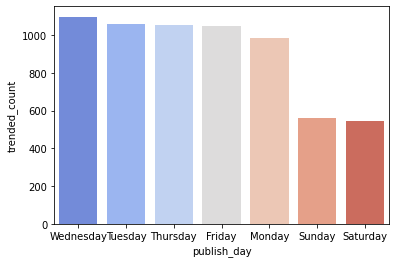

In [ ]:
#각 비디오가 공개된 요일에 대한 컬럼 추가
df["publish_day"] = df["publish_date"].apply(lambda x: x.strftime('%A'))

#시각화
sns.barplot(data=df.groupby("publish_day").sum()["trended_count"].sort_values(ascending=False).reset_index(),x="publish_day",y="trended_count",palette="coolwarm")

<AxesSubplot:xlabel='publish_day', ylabel='trended_count'>

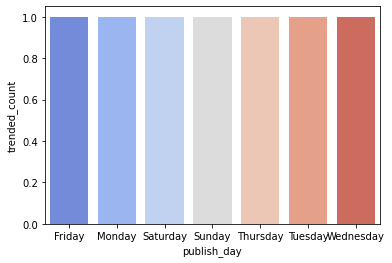

In [ ]:
sns.barplot(data=df.groupby("publish_day").mean()["trended_count"].sort_values(ascending=False).reset_index(),x="publish_day",y="trended_count",palette="coolwarm")

#별 차이없음

소결 : 게시 시간 또는 요일이 유의미한 차이를 만든다고 보기 어렵다.

2. 그러면 자주 올리는 사람이 인기영상에 더 오래 머무르나?

In [ ]:
# Unique videos
unique_videos = df[df["trended_count"] == df["days_trended_after_publish"]].groupby("channel_title").nunique()["video_id"].reset_index()
unique_videos.sort_values(by="video_id",ascending=False).head()

,channel_title,video_id
803,The Tonight Show Starring Jimmy Fallon,62
814,TheEllenShow,55
256,ESPN,52
400,Jimmy Kimmel Live,50
551,NBA,43


In [ ]:
# Total days between first and last published date
last_published = df[df["trended_count"] == df["days_trended_after_publish"]].groupby("channel_title").max()["publish_date"].reset_index()
last_published.head()

/var/folders/lt/b43bl65n2r38vrn01fzsz2lh0000gn/T/ipykernel_752/2323017172.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  last_published = df[df["trended_count"] == df["days_trended_after_publish"]].groupby("channel_title").max()["publish_date"].reset_index()


,channel_title,publish_date
0,1MILLION Dance Studio,2018-03-07
1,1theK (원더케이),2018-01-18
2,20th Century Fox,2018-05-15
3,5-Minute Crafts,2018-02-07
4,5FDPVEVO,2017-12-22


In [ ]:
first_published = df[df["trended_count"] == df["days_trended_after_publish"]].groupby("channel_title").min()["publish_date"].reset_index()
first_published.head()

/var/folders/lt/b43bl65n2r38vrn01fzsz2lh0000gn/T/ipykernel_752/3405808379.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  first_published = df[df["trended_count"] == df["days_trended_after_publish"]].groupby("channel_title").min()["publish_date"].reset_index()


,channel_title,publish_date
0,1MILLION Dance Studio,2018-02-28
1,1theK (원더케이),2018-01-04
2,20th Century Fox,2017-11-13
3,5-Minute Crafts,2017-12-03
4,5FDPVEVO,2017-12-01


In [ ]:
consistency = first_published.merge(last_published,on="channel_title")
consistency.columns = ["channel_title","first_published","last_published"]
consistency["total_days"] = consistency["last_published"] - consistency["first_published"]
consistency["total_days"] = consistency["total_days"].dt.days
consistency = consistency.merge(unique_videos,on="channel_title")
consistency["average_days_between_videos"] = consistency["total_days"]/consistency["video_id"]

consistency = consistency.merge(df[["video_id","channel_title","trended_count"]].drop_duplicates().groupby(by="channel_title").sum()["trended_count"].reset_index(),on="channel_title")
consistency.head()

,channel_title,first_published,last_published,total_days,video_id,average_days_between_videos,trended_count
0,1MILLION Dance Studio,2018-02-28,2018-03-07,7,2,3.500000,4
1,1theK (원더케이),2018-01-04,2018-01-18,14,3,4.666667,5
2,20th Century Fox,2017-11-13,2018-05-15,183,9,20.333333,17
3,5-Minute Crafts,2017-12-03,2018-02-07,66,2,33.000000,3
4,5FDPVEVO,2017-12-01,2017-12-22,21,2,10.500000,2


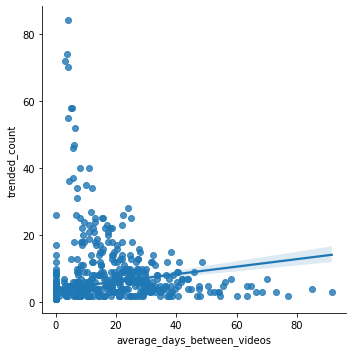

In [ ]:
sns.lmplot(data=consistency,x="average_days_between_videos",y="trended_count")

In [ ]:
df.isnull().sum()

#결측값 대체

video_id                        0
trending_date                   0
title                           0
channel_title                   0
category                        0
category_id                     0
publish_time                    0
tags                            0
views                           0
likes                           0
dislikes                        0
comment_count                   0
thumbnail_link                  0
comments_disabled               0
ratings_disabled                0
video_error_or_removed          0
description                   102
publish_date                    0
publish_time_of_day             0
publish_hour                    0
days_trended_after_publish      0
trended_count                   0
treTime-pubTime                 0
tag_count                       0
likes/views                     0
dislikes/views                  0
comment_count/views             0
dislikes/likes                  0
like_percent                    0
dislike_percen

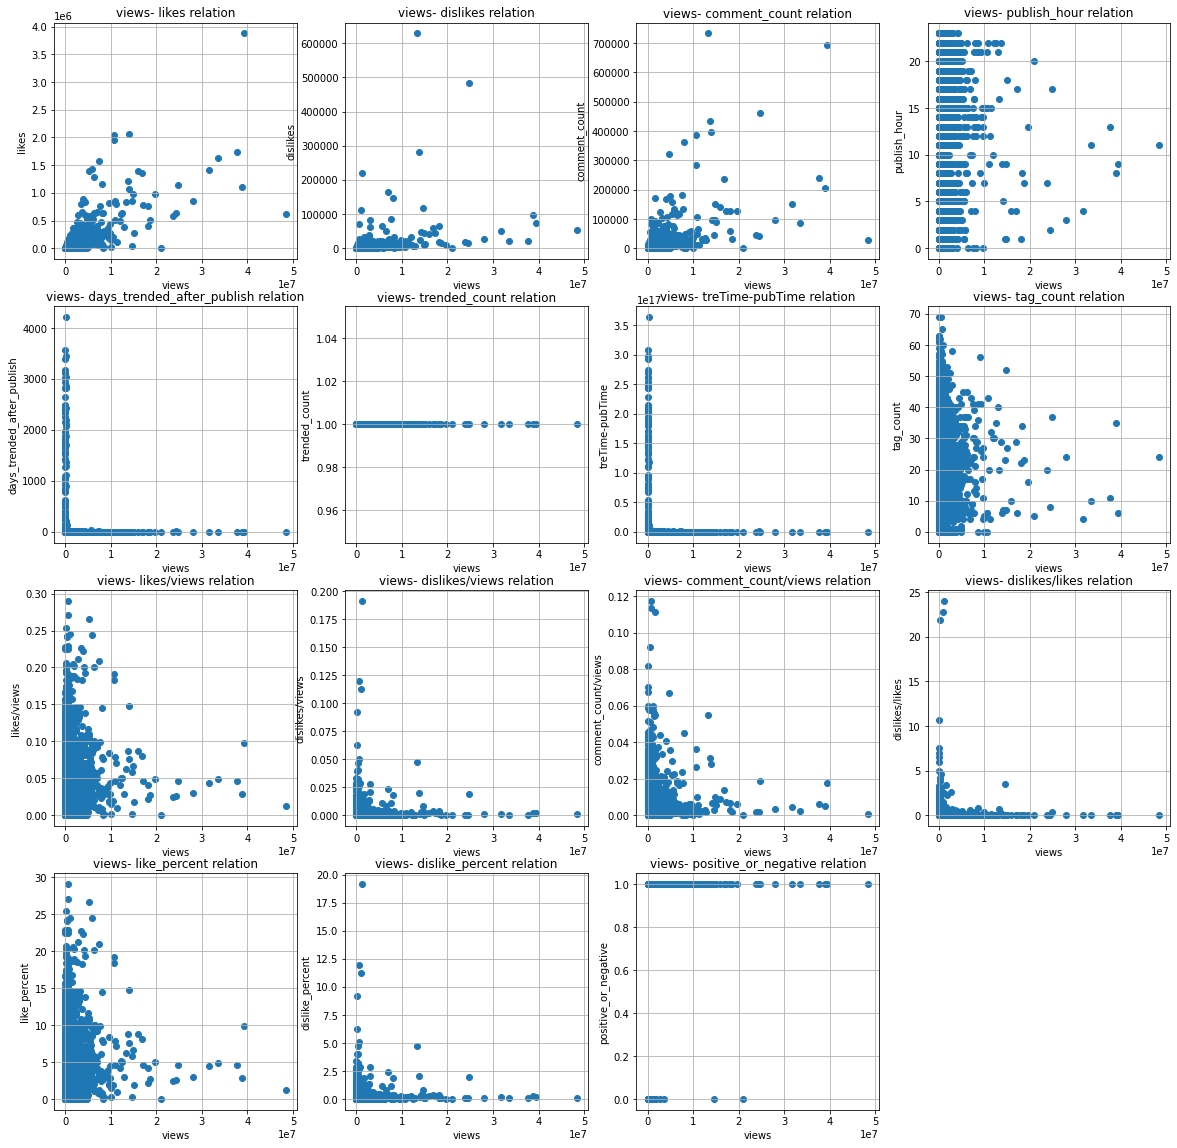

In [ ]:
plt.figure(figsize = (20, 20))

for i in range(1, len(df.describe().columns) - 1 ):
    plt.subplot(4, 4, i)
    plt.title("views- {} relation".format(df.describe().columns[i]))
    plt.xlabel("views")
    plt.ylabel(df.describe().columns[i])
    plt.scatter(x = df["views"], y = df[df.describe().columns[i]])
    plt.grid()

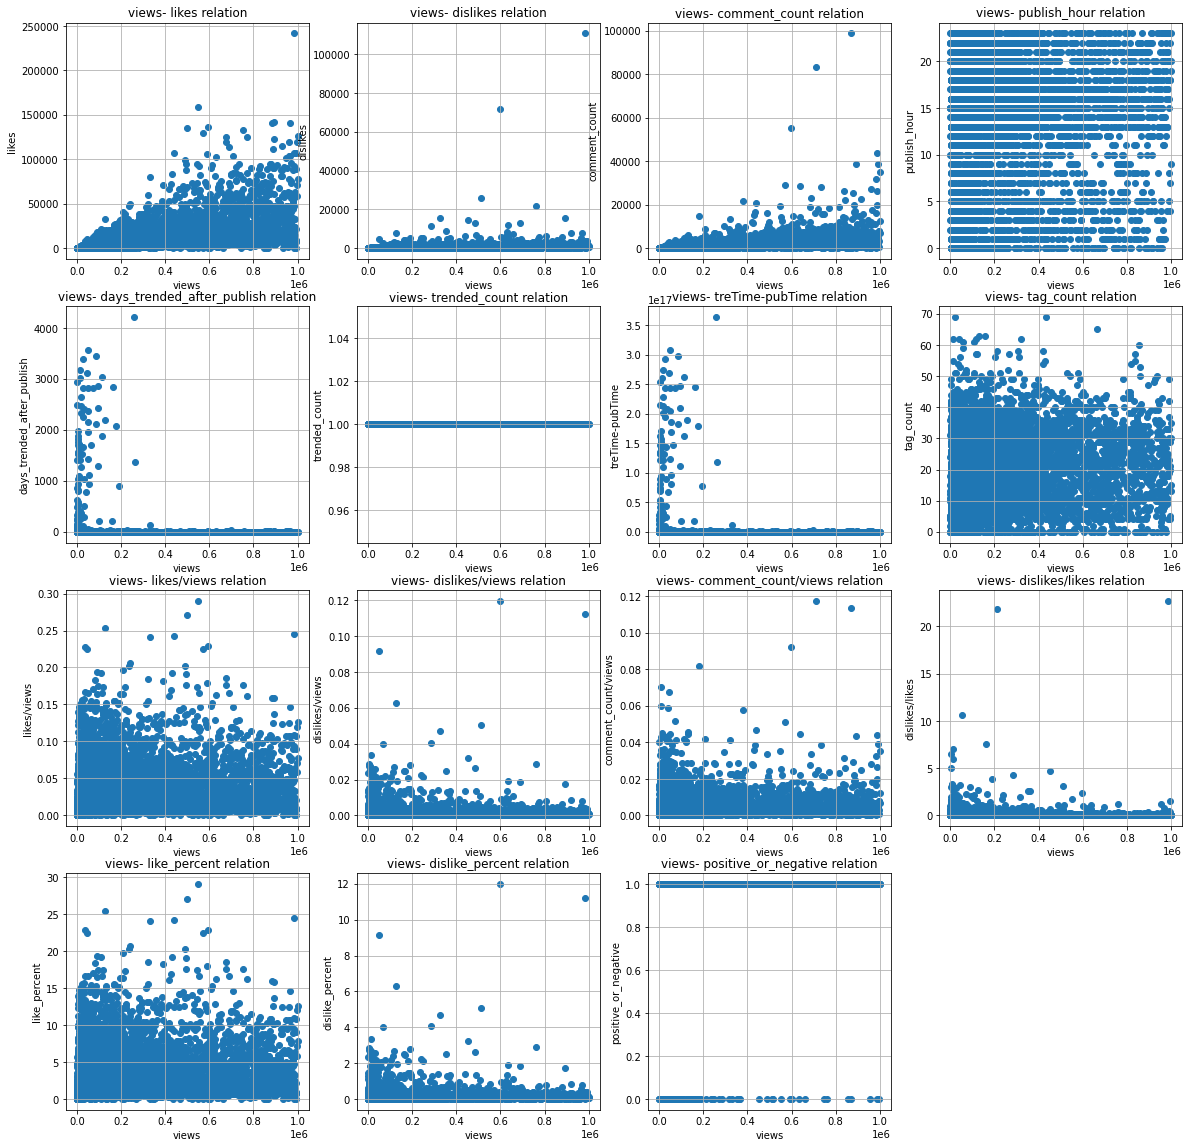

In [ ]:
#outlier제거 후

plt.figure(figsize = (20, 20))

for i in range(1, len(df.describe().columns) - 1 ):
    plt.subplot(4, 4, i)
    plt.title("views- {} relation".format(df.describe().columns[i]))
    plt.xlabel("views")
    plt.ylabel(df.describe().columns[i])
    plt.scatter(x = df["views"].loc[df["views"] <= 1000000], y = df[df.describe().columns[i]].loc[df["views"] <= 1000000])
    plt.grid()
    
#likes만 뚜렷해보임

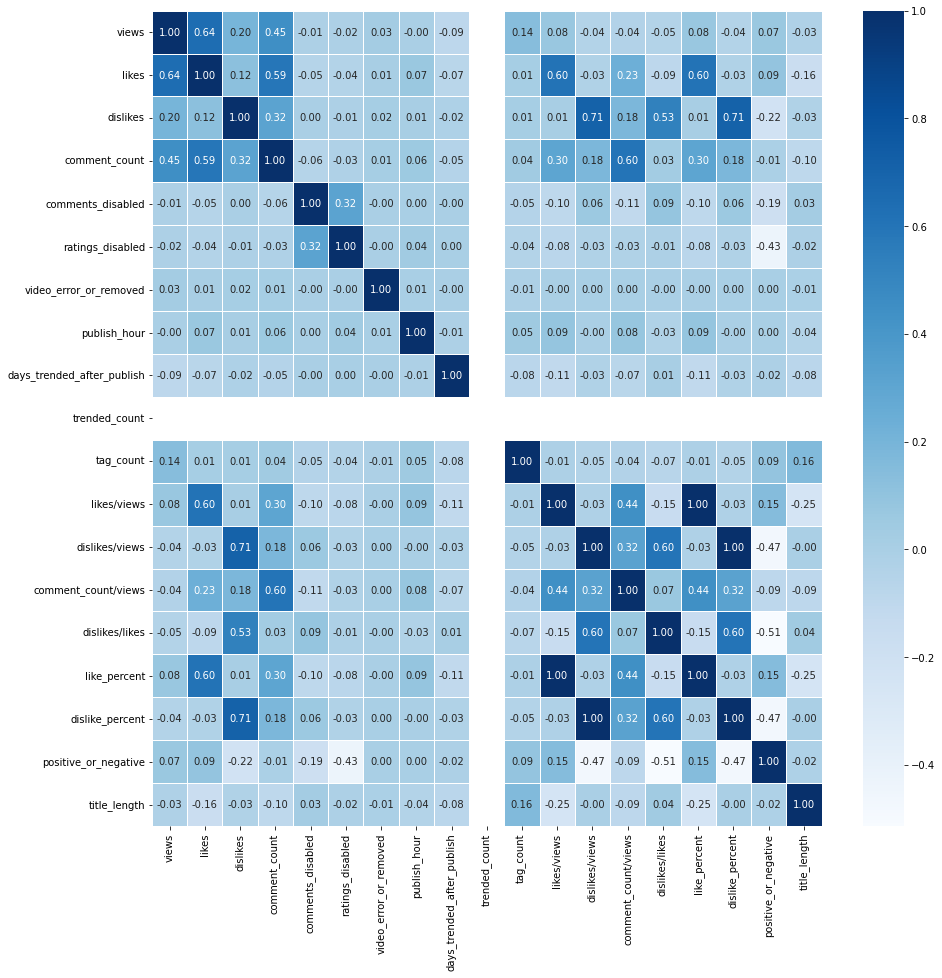

In [ ]:
#조회수 상위 데이터를 제외한 상관관계
#좋아요와 싫어요를 누르거나 댓글을 남기려면 먼저 동영상을 조회해야하기 때문에, 조회수가 likes, dislikes, comment_count에 영향을 준다고 해석해야 

plt.figure(figsize = (15,15))
sns.heatmap(data = df.loc[df["views"] <= 1000000].corr(method="pearson"), annot = True, fmt = ".2f", linewidths = .5, cmap = "Blues");


영상 카테고리

In [ ]:
print("전체 데이터 {}개\ncategory 개수 {}개\n".format(len(df),len(df["category"].unique())))
for i in range(len(df["category"].value_counts())):
    print("{:23} {:4} {:.2f}".format(df["category"].value_counts().index[i],
                            df["category"].value_counts().values[i],
                            df["category"].value_counts(normalize = True).values[i]))
#전체 데이터 6351개 , category 개수 16개

전체 데이터 6351개
category 개수 16개

Entertainment           1619 0.25
Music                    799 0.13
Howto & Style            595 0.09
Comedy                   547 0.09
News & Politics          505 0.08
People & Blogs           498 0.08
Sports                   451 0.07
Science & Technology     380 0.06
Film & Animation         318 0.05
Education                250 0.04
Pets & Animals           138 0.02
Gaming                   103 0.02
Autos & Vehicles          70 0.01
Travel & Events           60 0.01
Nonprofits & Activism     14 0.00
Shows                      4 0.00


<AxesSubplot:xlabel='views', ylabel='category'>

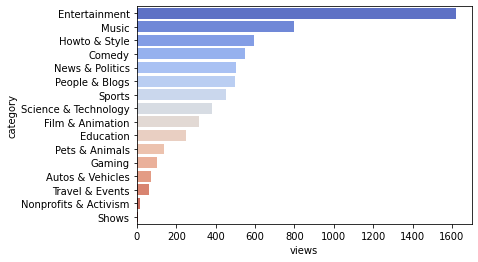

In [ ]:
sns.barplot(data=df.groupby("category").count()["views"].reset_index().sort_values(by="views",ascending=False),x="views",y="category",palette="coolwarm")

<AxesSubplot:xlabel='trended_count', ylabel='category'>

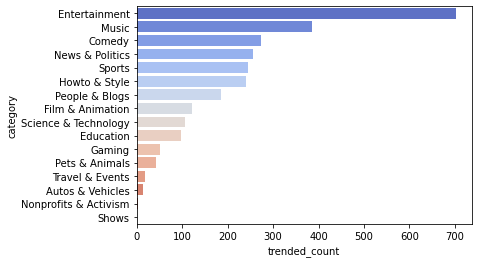

In [ ]:
sns.barplot(data=df[df["trended_count"] == df["days_trended_after_publish"]].groupby(by="category").sum()["trended_count"].reset_index().sort_values(by="trended_count",ascending=False),y="category",x="trended_count",palette="coolwarm")

#ent가 오래 머무름

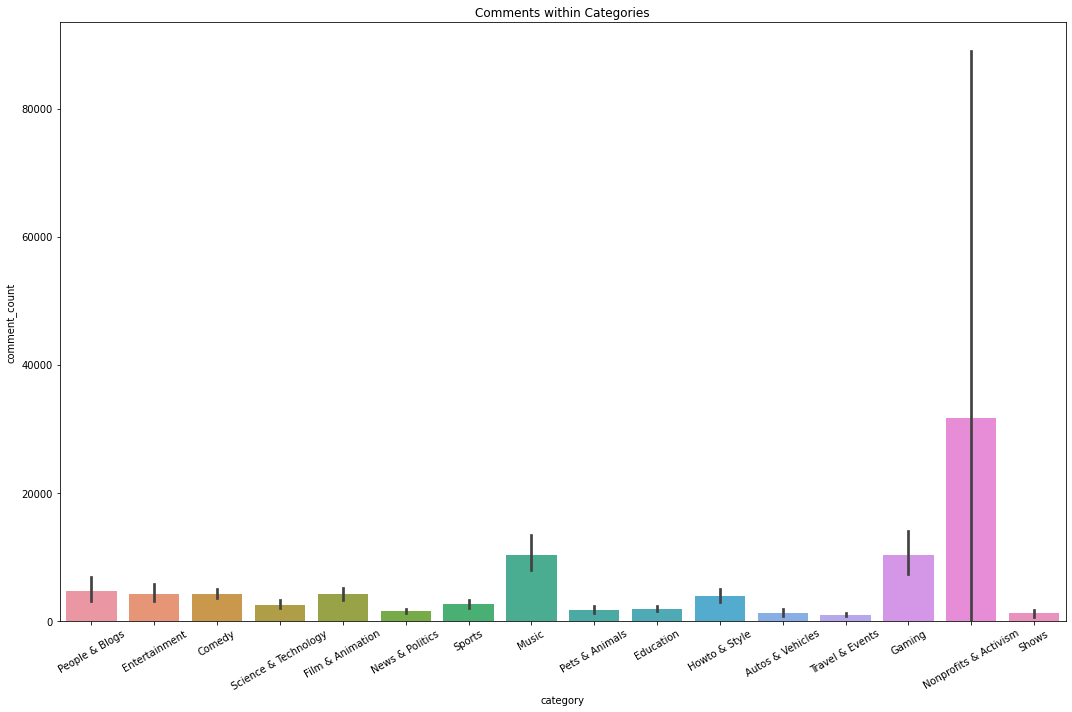

In [ ]:
plt.figure(figsize=(15,10))
g = sns.barplot(x=df['category'],y=df['comment_count'],data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=30)
plt.title('Comments within Categories')
plt.tight_layout()
# it looks like non profits seem to have the most 'comment' activities

Text(0.5, 1.0, 'Correlation of Likes and Dislikes')

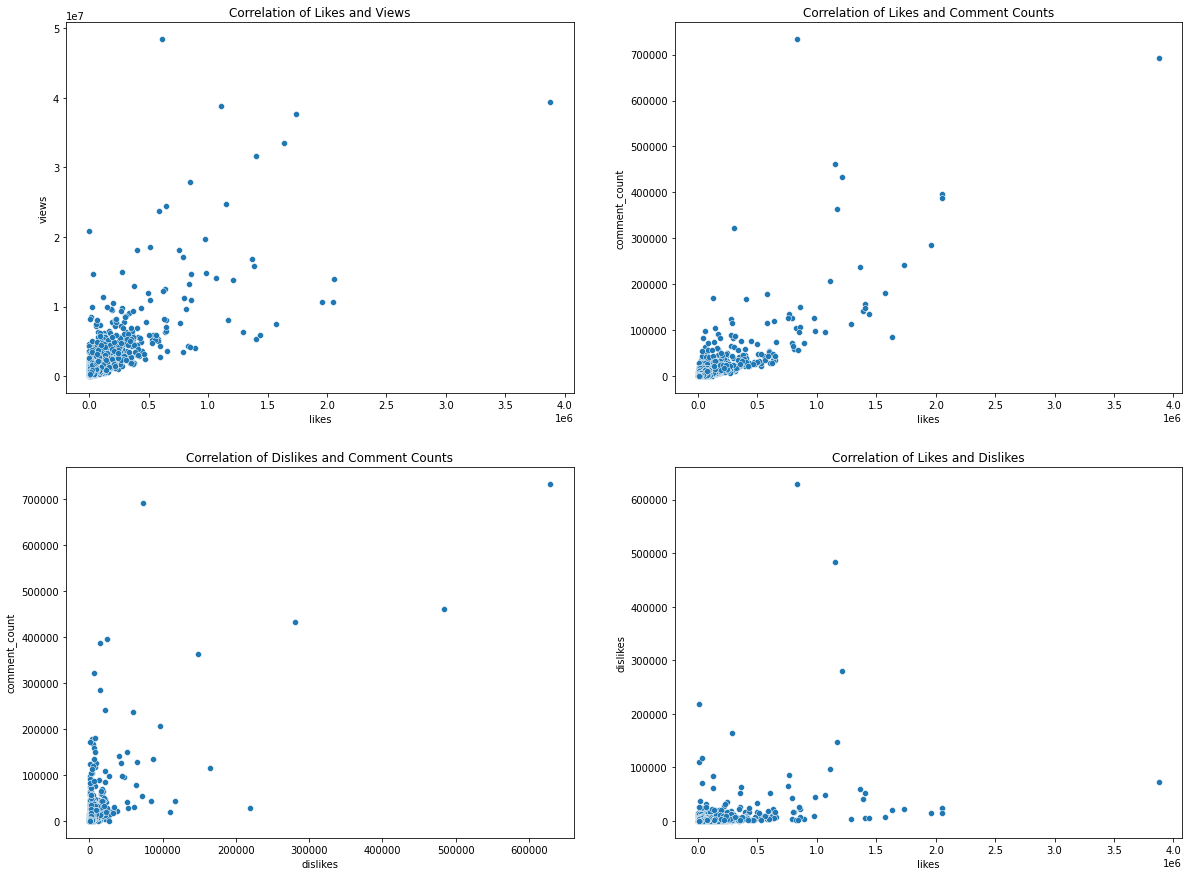

In [ ]:
f, ax = plt.subplots(2,2,figsize=(20,15))
# 1st chart (likes : views)
g = sns.scatterplot(x=df['likes'],y=df['views'],data=df,ax=ax[0][0])
g.set_title('Correlation of Likes and Views')
# 2nd chart (likes : communt_count)
g1 = sns.scatterplot(x=df['likes'],y=df['comment_count'],data=df,ax=ax[0][1])
g1.set_title('Correlation of Likes and Comment Counts')
# 3rd chart (comment_count : dislikes)
g2 = sns.scatterplot(x=df['dislikes'],y=df['comment_count'],data=df,ax=ax[1][0])
g2.set_title('Correlation of Dislikes and Comment Counts')
# 4th chart (likes : dislikes)
g3 = sns.scatterplot(x=df['likes'],y=df['dislikes'],data=df,ax=ax[1][1])
g3.set_title('Correlation of Likes and Dislikes')

In [ ]:
pd.set_option('display.max_columns', None)
df

,video_id,trending_date,title,channel_title,category,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,publish_date,publish_time_of_day,publish_hour,days_trended_after_publish,trended_count,treTime-pubTime,tag_count,likes/views,dislikes/views,comment_count/views,dislikes/likes,like_percent,dislike_percent,positive_or_negative,title_length,publish_day
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,People & Blogs,22,2017-11-13 17:13:01,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,2017-11-13,17:13:01,17,1,1,1 days 06:46:59,1,0.076869,0.003963,0.021318,0.051558,7.686932,0.396326,1,34,Monday
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,Entertainment,24,2017-11-13 07:30:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",2017-11-13,07:30:00,7,1,1,1 days 16:30:00,4,0.040179,0.002541,0.005252,0.063240,4.017930,0.254095,1,62,Monday
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,Comedy,23,2017-11-12 19:05:24,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,2017-11-12,19:05:24,19,2,1,2 days 04:54:36,23,0.045758,0.001673,0.002563,0.036560,4.575780,0.167292,1,53,Sunday
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,Entertainment,24,2017-11-13 11:00:04,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,2017-11-13,11:00:04,11,1,1,1 days 12:59:56,27,0.029641,0.001941,0.006253,0.065474,2.964146,0.194074,1,32,Monday
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,Entertainment,24,2017-11-12 18:01:41,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,2017-11-12,18:01:41,18,2,1,2 days 05:58:19,14,0.063097,0.000949,0.008359,0.015041,6.309732,0.094907,1,24,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6346,dS5Thrl-4Kc,2018-06-14,CRAYOLA MAKEUP | HIT OR MISS?,Laura Lee,Howto & Style,26,2018-06-12 18:55:26,"Laura88Lee|""crayola""|""crayon makeup""|""crayola ...",607422,26166,895,3517,https://i.ytimg.com/vi/dS5Thrl-4Kc/default.jpg,False,False,False,"Hey Larlees, todays video is me testing Crayol...",2018-06-12,18:55:26,18,2,1,2 days 05:04:34,21,0.043077,0.001473,0.005790,0.034205,4.307714,0.147344,1,29,Tuesday
6347,JGm9Y_hFqNk,2018-06-14,First Take reacts: Kyrie Irving says contract ...,ESPN,Sports,17,2018-06-13 15:06:08,"espn|""espn live""|""boston celtics""|""kyrie irvin...",812832,7701,320,2505,https://i.ytimg.com/vi/JGm9Y_hFqNk/default.jpg,False,False,False,First Take's Stephen A. Smith and Max Kellerma...,2018-06-13,15:06:08,15,1,1,1 days 08:53:52,31,0.009474,0.000394,0.003082,0.041553,0.947428,0.039369,1,94,Wednesday
6348,6h8QgZF5Qu4,2018-06-14,Drop the Mic w/ Ashton Kutcher & Sean Diddy Combs,The Late Late Show with James Corden,Entertainment,24,2018-06-13 05:27:27,"The Late Late Show|""Late Late Show""|""James Cor...",864189,18811,399,1074,https://i.ytimg.com/vi/6h8QgZF5Qu4/default.jpg,False,False,False,James Corden and Ashton Kutcher square off in ...,2018-06-13,05:27:27,5,1,1,1 days 18:32:33,28,0.021767,0.000462,0.001243,0.021211,2.176723,0.046170,1,49,Wednesday
6349,mpnshdmtE2Y,2018-06-14,Carla Makes BA 

VIEW 수를 예측하는 모델 만들기

In [ ]:
df.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category',
       'category_id', 'publish_time', 'tags', 'views', 'likes', 'dislikes',
       'comment_count', 'thumbnail_link', 'comments_disabled',
       'ratings_disabled', 'video_error_or_removed', 'description',
       'publish_date', 'publish_time_of_day', 'publish_hour',
       'days_trended_after_publish', 'trended_count', 'treTime-pubTime',
       'tag_count', 'likes/views', 'dislikes/views', 'comment_count/views',
       'dislikes/likes', 'like_percent', 'dislike_percent',
       'positive_or_negative', 'title_length', 'publish_day'],
      dtype='object')

In [ ]:
X = df[['likes','dislikes',
        'comment_count','days_trended_after_publish','tag_count', 'positive_or_negative']]
y = df['views']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

SelectKBest

In [ ]:
from sklearn.feature_selection import f_regression, SelectKBest
selector = SelectKBest(score_func=f_regression, k=3)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

all_names = X_train.columns
selected_mask = selector.get_support()

selected_names = all_names[selected_mask]
print('Selected names: ', selected_names)

Selected names:  Index(['likes', 'dislikes', 'comment_count'], dtype='object')


In [ ]:
#기준모델 : view 평균
predict = y_train.mean()
predict

772438.0150731158

In [ ]:
# 기준모델로 훈련 에러(MAE) 계산
from sklearn.metrics import mean_absolute_error
y_pred = [predict] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)

print(f'훈련 에러: {mae:.2f}')

훈련 에러: 826473.75


In [ ]:
# 테스트 에러(MAE)
y_pred = [predict] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트 에러: {mae:.2f}')

테스트 에러: 769432.35


LinearRegression

In [ ]:
#scikit-learn을 사용해 다중선형회귀 모델 제작

from sklearn.linear_model import LinearRegression

model1 = LinearRegression()

# 모델 fit
model1.fit(X_train, y_train)
y_pred = model1.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'훈련 에러: {mae:.2f}')

print(model1.intercept_)

훈련 에러: 462410.72
147261.95533661882


In [ ]:
print("훈련 세트의 정확도 : {:.2f}".format(model1.score(X_train, y_train)))
print("테스트 세트의 정확도 : {:.2f}".format(model1.score(X_test, y_test)))
print("사용한 특성의 수 : {}".format(np.sum(model1.coef_ != 0)))

훈련 세트의 정확도 : 0.60
테스트 세트의 정확도 : 0.69
사용한 특성의 수 : 6


In [ ]:
X_train.columns

Index(['likes', 'dislikes', 'comment_count', 'days_trended_after_publish',
       'tag_count', 'positive_or_negative'],
      dtype='object')

In [ ]:
cdf = pd.DataFrame(model1.coef_,index = X_train.columns,columns=['Coefficients'])
cdf

,Coefficients
likes,16.978543
dislikes,68.673912
comment_count,-45.684465
days_trended_after_publish,-79.262447
tag_count,7156.184230
positive_or_negative,1679.034796


In [ ]:
predictions = model1.predict(X_test)
predictions

array([ 604290.88249227,  669829.99885336,  396292.51160125, ...,
        427177.12524468, 1462220.42001639,  445558.2530441 ])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


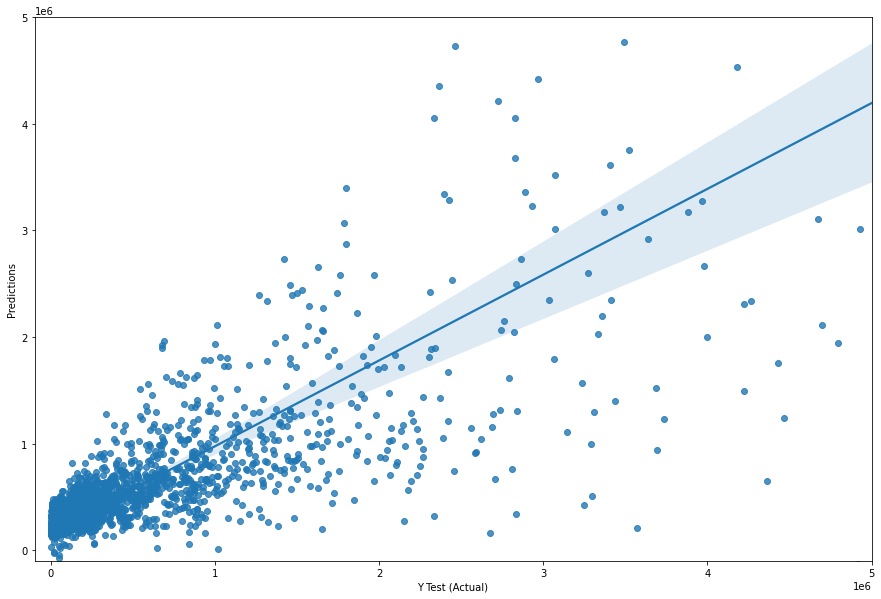

In [ ]:
plt.figure(figsize=(15,10))
g = sns.regplot(y_test,predictions,fit_reg=True)
plt.xlabel('Y Test (Actual)')
plt.ylabel('Predictions')
g.set(xlim=(-100000,5000000),ylim=(-100000,5000000))
plt.show(g)

In [ ]:
from sklearn import metrics

model1.score(X_test,y_test)

0.6903536070856763

In [ ]:
print('MAE :',metrics.mean_absolute_error(y_test,predictions))
print('MSE :',metrics.mean_squared_error(y_test,predictions))
print('RMSE :',np.sqrt(metrics.mean_squared_error(y_test,predictions)))

MAE : 414310.9000311759
MSE : 914122528660.0659
RMSE : 956097.5518534005


LASSO

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso


#확인해보고 싶은 경우들을 파이썬 딕셔너리로 저장
hyper_parameter = {
		'alpha' : [0.1, 10, 100, 200, 500],
		'max_iter' : [100, 500, 1000, 2000, 2500]
}

lasso_model = Lasso()   #라쏘모델로 학습한다는 설정, 하이퍼파라미터를 안넣어주고 학습!

#최적의 하이퍼 파라미터 조합을 찾아줄 도구GridSearchCV를 정의
hyper_parameter_tuner = GridSearchCV(lasso_model, hyper_parameter, cv=5)

#fit 메소드를 사용해서 주어진 데이터에서 최고의 성능을 갖는 하이퍼 파라미터 조합을 계산
hyper_parameter_tuner.fit(X,y)
#fit 메소드를 실행시키면 hyper_parameter_tuner의 best_params_ 변수에 실험한 하이퍼 파라미터들 중 가장 성능이 좋은 조합이 저장
#실행해보면 워닝이 엄청 많이 나오는데, 대체로 설정한 max_iter값이 충분하지 않은 모델이 있어 원하는 최적점을 찾을 수 없었다는 얘기

best_params = hyper_parameter_tuner.best_params_
best_params
#{'alpha': 500, 'max_iter': 100}

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.596e+15, tolerance: 1.866e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.705e+15, tolerance: 2.222e+12
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

{'alpha': 500, 'max_iter': 100}

In [ ]:
lasso_01 = Lasso(alpha= 500, max_iter= 100).fit(X_train, y_train)


print("훈련 세트의 정확도 : {:.2f}".format(lasso_01.score(X_train, y_train)))
print("테스트 세트의 정확도 : {:.2f}".format(lasso_01.score(X_test, y_test)))
print("사용한 특성의 수 : {}".format(np.sum(lasso_01.coef_ != 0)))
print("사용한 max_iter : {}".format(lasso_01.n_iter_))

#그리드서치왜함?
#alpha값을 낮추면 규제의 효과가 없어져 과대적합이 되므로 LinearRegression의 결과와 비슷해진다.

print('MAE :',metrics.mean_absolute_error(y_test,predictions))
print('MSE :',metrics.mean_squared_error(y_test,predictions))
print('RMSE :',np.sqrt(metrics.mean_squared_error(y_test,predictions)))

훈련 세트의 정확도 : 0.60
테스트 세트의 정확도 : 0.69
사용한 특성의 수 : 5
사용한 max_iter : 99
MAE : 414310.9000311759
MSE : 914122528660.0659
RMSE : 956097.5518534005


RidgeCV

In [ ]:
from sklearn.linear_model import Ridge


alphas = np.logspace(-4, 0, 200)
parameters = {'alpha': [1, 10] }
model2 = Ridge()

ridge_reg = GridSearchCV(model2, parameters, scoring='neg_mean_squared_error',cv=5)
ridge_reg.fit(X,y)
print(ridge_reg.best_params_)
print(ridge_reg.best_score_)

# best estimator
print(ridge_reg.best_estimator_)

# best model
best_model = ridge_reg.best_estimator_
best_model.fit(X,y)
#{'alpha': 10} -1490811037343.106

{'alpha': 10}
-1490630471128.6968
Ridge(alpha=10)


Ridge(alpha=10)

In [ ]:
# Ridge 모델 선언
# alpha값을 높이면 계수를 0에 더 가깝게 만들어 훈련세트의 성능은 나빠지지만 일반화에는 쉬워진다.
# 반대로 alpha값을 줄이면 계수에 대한 제약이 그만큼 풀리면서 LinearRegression으로 만든 모델과 거의 같아진다.

for alpha in alphas:
      ridge = Ridge(alpha=10, normalize=True)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')
print(f'R2 Score: {r2:,.4f}\n')

print('MAE :',metrics.mean_absolute_error(y_test,predictions))
print('MSE :',metrics.mean_squared_error(y_test,predictions))
print('RMSE :',np.sqrt(metrics.mean_squared_error(y_test,predictions)))

Test MAE: $689,385
R2 Score: 0.2529

MAE : 414310.9000311759
MSE : 914122528660.0659
RMSE : 956097.5518534005


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, r2_score

alphas = [0, 0.001, 0.01, 0.1, 1]

# RidgeCV는 alpha로 넣고자 하는 값들을 리스트로 전달하면 내부적으로 최적의 alpha값을 찾아냄
ridgecv = RidgeCV(alphas=alphas, normalize=True, cv=5)
# cv : cross-validation -> 데이터를 k등분한 후 각각에 대하여 검증 진행
# 검증 결과 가장 점수가 높은 모델을 채택
ridgecv.fit(X_train, y_train)
y_pred = ridgecv.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')
print(f'R2 Score: {r2:,.4f}\n')

print(f'alpha: {ridgecv.alpha_}') # 최종 결정된 alpha값
print(f'cv best score: {ridgecv.best_score_}') # 최종 alpha에서의 점수(R^2 of self.predict(X) wrt. y.)

print("훈련 세트의 정확도 : {:.2f}".format(ridgecv.score(X_train, y_train)))
print("테스트 세트의 정확도 : {:.2f}".format(ridgecv.score(X_test, y_test)))
print("사용한 특성의 수 : {}".format(np.sum(ridgecv.coef_ != 0)))

Test MAE: $412,934
R2 Score: 0.6990

alpha: 0.01
cv best score: 0.5753939688232694
훈련 세트의 정확도 : 0.60
테스트 세트의 정확도 : 0.70
사용한 특성의 수 : 6


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler

XGB

In [ ]:
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

pipe = make_pipeline(
    
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.3
                 )
)

pipe.fit(X_train, y_train);

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error


predictions1 = pipe.predict(X_test)
predictions1

print('MAE :',metrics.mean_absolute_error(y_test,predictions1))
print('MSE :',metrics.mean_squared_error(y_test,predictions1))
print('RMSE :',np.sqrt(metrics.mean_squared_error(y_test,predictions1)))
R2 = r2_score(y_test, predictions1)
print(R2)   #테스트셋이 작아서 버그인것같음 음수는
#그냥선형회귀보다 다 더 커졌음..

print("훈련 세트의 정확도 : {:.2f}".format(ridgecv.score(X_train, y_train)))
print("테스트 세트의 정확도 : {:.2f}".format(ridgecv.score(X_test, y_test)))
print("사용한 특성의 수 : {}".format(np.sum(ridgecv.coef_ != 0)))

MAE : 722878.5073452255
MSE : 3473441264826.973
RMSE : 1863717.056000447
-0.17658029961254584
훈련 세트의 정확도 : -1787181.78
테스트 세트의 정확도 : 0.70
사용한 특성의 수 : 6
